# WD Database for Python

The goal is to download the following database: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J%2FMNRAS%2F455%2F3413 for use in a machine-learning inspired scheme to 

In [1]:
#Preamble. Standard packages for to load
import astropy
from astropy.table import Table, Column, MaskedColumn, vstack 
import numpy as np
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
import urllib2
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
from astroquery.sdss import SDSS
from astropy import units as u
from astropy import coordinates as coords
from astropy.io import fits
import astropy.io.ascii as ascii
from astropy.modeling import models, fitting
from numpy import ones
from numpy.linalg import lstsq
import os
import random

//anaconda/envs/py27/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
catalog_list_1 = Vizier.find_catalogs('New white dwarf SDSS DR12')
catalog_list_2 = Vizier.find_catalogs('J/ApJS/204/5')
catalog_list_3 = Vizier.find_catalogs('J/MNRAS/446/4078')

In [3]:
print({k:v.description for k,v in catalog_list_1.items()})
print({k:v.description for k,v in catalog_list_2.items()})
print({k:v.description for k,v in catalog_list_3.items()})

{u'J/MNRAS/455/3413': u'New white dwarf and subdwarf stars in SDSS DR12 (Kepler+, 2016)'}
{u'J/ApJS/204/5': u'SDSS DR7 white dwarf catalog (Kleinman+, 2013)'}
{u'J/MNRAS/446/4078': u'New white dwarf stars in SDSS DR10 (Kepler+, 2015)'}


In [4]:
Vizier.ROW_LIMIT = -1
catalogs_1 = Vizier.get_catalogs(catalog_list_1.keys())
catalogs_2 = Vizier.get_catalogs(catalog_list_2.keys())
catalogs_3 = Vizier.get_catalogs(catalog_list_3.keys())

//anaconda/envs/py27/lib/python2.7/site-packages/astroquery/vizier/core.py:683: UserWarning: VOTABLE parsing raised exception: None:336:189: ValueError: invalid literal for int() with base 10: 'null' (in row 147, col 'f_umag')
  warnings.warn("VOTABLE parsing raised exception: {0}".format(ex))


In [5]:
print(catalogs_1)
print(catalogs_2)
print(catalogs_3)

TableList with 1 tables:
	'0:J/MNRAS/455/3413/table6' with 34 column(s) and 6647 row(s) 
TableList with 1 tables:
	'0:J/ApJS/204/5/table2' with 45 column(s) and 20407 row(s) 
TableList with 1 tables:
	'0:J/MNRAS/446/4078/table6' with 30 column(s) and 9112 row(s) 


In [6]:
catalogs = vstack([catalogs_1[0], catalogs_2[0], catalogs_3[0]])

In [7]:
catalogs

_RAJ2000,_DEJ2000,PMF,SDSS,S_N,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,E_B-V_,pm,GLON,GLAT,SpType,Teff,e_Teff,logg,e_logg,Teff_3D_,e_Teff_3D_,logg_3D_,e_logg_3D_,Mass,e_Mass,Com,Sp,_RA.icrs,_DE.icrs,Plate,MJD,Fiber,RAJ2000,DEJ2000,SNg,f_umag,f_gmag,f_rmag,f_imag,f_zmag,f_pm,pmPA,Ag,GMT,Atype,log_g_,e_log_g_,chi2,m_Nsp,Nsp,q_Nsp,Type,WDcat,DR7,Sloan,Simbad,PMJ,_RA,_DE
deg,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,0.01 / yr,deg,deg,,K,K,[cm/s2],[cm/s2],K,K,[cm/s2],[cm/s2],Msun,Msun,,,deg,deg,,d,,deg,deg,,,,,,,,deg,mag,"""datime""",,[cm/s2],[cm/s2],,,,,,,,,,,deg,deg
float64,float64,str15,str19,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str9,int32,int32,float32,float32,int32,int32,float32,float32,float64,float64,str69,str2,float64,float64,int16,int32,int16,float64,float64,float32,int64,int64,int64,int64,int64,uint8,float32,float32,str20,str14,float32,float32,float32,str4,int16,str1,str19,int16,str3,str5,str6,str15,float64,float64
192.84360,-2.67170,0337-51997-0195,125122.06-023737.21,22,18.12,0.02,17.57,0.02,17.55,0.01,17.57,0.02,17.60,0.02,0.021,5.10,302.9,60.2,sdB,29108,463,5.409,0.087,--,--,--,--,--,--,,Sp,192.8436,-2.6717,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
232.78030,55.01910,0614-53437-0049,153112.62+550139.60,22,17.61,0.01,17.83,0.02,18.32,0.02,18.67,0.02,18.96,0.04,0.018,8.30,88.1,49.9,sdB,29876,374,5.292,0.080,--,--,--,--,--,--,,Sp,232.7803,55.0191,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
221.71480,58.15350,0790-52346-0634,144657.14+580920.12,46,15.84,0.01,15.67,0.01,15.67,0.02,15.70,0.02,15.76,0.02,0.010,3.90,97.9,53.0,sdB,30893,165,5.033,0.032,--,--,--,--,--,--,,Sp,221.7148,58.1535,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
117.37760,28.08670,1059-52618-0515,074915.66+280641.01,11,18.91,0.02,19.10,0.03,19.52,0.02,19.86,0.03,20.15,0.11,0.035,4.60,192.5,24.3,sdB,29404,704,5.450,0.142,--,--,--,--,--,--,,Sp,117.3776,28.0867,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
326.60840,-7.21670,1177-52824-0636,214627.88-071117.59,45,16.16,0.01,15.94,0.03,15.86,0.01,15.86,0.01,15.90,0.02,0.035,7.00,48.6,-41.9,sdB,30503,191,5.019,0.036,--,--,--,--,--,--,,Sp,326.6084,-7.2167,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
63.90770,25.61750,1254-52972-0163,041536.05+253857.11,41,16.14,0.01,16.27,0.01,16.46,0.01,16.65,0.01,16.83,0.02,0.483,6.10,170.4,-17.9,He-sdO,64329,1429,6.118,0.073,--,--,--,--,--,--,,Sp,63.9077,25.6175,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
251.22790,21.59420,1569-53168-0370,164453.35+213711.54,20,17.75,0.02,17.82,0.01,18.22,0.01,18.55,0.01,18.81,0.04,0.050,3.00,40.5,37.0,sdB,26349,889,5.114,0.104,--,--,--,--,--,--,,Sp,251.2279,21.5942,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
244.92500,24.15590,1574-53476-0225,161942.83+240715.70,46,16.79,0.02,16.42,0.02,16.46,0.02,16.48,0.01,16.57,0.02,0.067,11.90,41.5,43.3,sdB,27741,342,5.227,0.048,--,--,--,--,--,--,,Sp,244.9250,24.1559,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [8]:
#This is a way to add coordinates if we need to. I don't think we need to right now.
#catalogs['Coordinates'] = coords.SkyCoord(catalogs['_RAJ2000'], catalogs['_DEJ2000'], frame='icrs')

In [9]:
#Here we do clean-up trying to merge those columns which were not properly merged
#because they were named different things in different catalogs. These include
#SDSS identifiers, a weird underscore for a log(g) parameter, different ways of
#specifying spectral type, and different ways of calibrating signal to noise.

PMF = catalogs['PMF']

for ind,obj in enumerate(PMF):
    if type(obj) != np.ma.core.MaskedConstant:
        split_PMF = obj.split('-')
        catalogs['Plate'][ind] = split_PMF[0]
        catalogs['MJD'][ind] = split_PMF[1]
        catalogs['Fiber'][ind] = split_PMF[2]
        
PMJ = catalogs['PMJ']

for ind,obj in enumerate(PMJ):
    if type(obj) != np.ma.core.MaskedConstant:
        split_PMJ = obj.split('-')
        catalogs['Plate'][ind] = split_PMJ[0]
        catalogs['MJD'][ind] = split_PMJ[1]
        catalogs['Fiber'][ind] = split_PMJ[2]

log_g_ah = catalogs['log_g_']

for ind,obj in enumerate(log_g_ah):
    if type(catalogs['logg'][ind]) == np.ma.core.MaskedConstant:
        if type(obj) != np.ma.core.MaskedConstant:
            catalogs['logg'][ind] = obj
            catalogs['e_logg'][ind] = catalogs['e_log_g_'][ind] 

Types = catalogs['SpType']

for ind,obj in enumerate(Types):
    if type(catalogs['Type'][ind]) == np.ma.core.MaskedConstant:
        if type(obj) != np.ma.core.MaskedConstant:
            catalogs['Type'][ind] = obj
            
SN = catalogs['SNg']

for ind,obj in enumerate(SN):
    if type(catalogs['S_N'][ind]) == np.ma.core.MaskedConstant:
        if type(obj) != np.ma.core.MaskedConstant:
            catalogs['S_N'][ind] = obj

### Let's select a quality sample of WD spectra of Type DA

In [10]:
WD = catalogs[catalogs['Type'] == 'DA']

print("We start with", len(WD), "WDs")

# First, we want to remove systems with NaN's - only found in log g
good_WD = WD[np.where(~np.isnan(WD['logg']))]
print("We removed", len(WD[np.isnan(WD['logg'])]), "systems with NaNs")

# Now, we want to remove systems in which the log g was assumed. These all have e_logg=0.0
good_WD = good_WD[good_WD['e_logg'] != 0.0]
print("Number with determined log g",len(good_WD))

# Next, we only want objects with a S/N above 10
good_WD = good_WD[good_WD['S_N']>10]
print("Number with S/N > 10",len(good_WD))

# Next, we want objects with log g uncertainties smaller than, say, 0.2
good_WD = good_WD[good_WD['e_logg']<0.2]
print("Number with log g error less than 0.2",len(good_WD))

# # Let's do the same with T_eff uncertainties - limit to 15% of T_eff
# good_WD = good_WD[good_WD['e_Teff']<0.15*good_WD['Teff']]
# print("Number with Teff uncertainties less than 15%",len(good_WD))

# Print the median Teff error
print("Median T_eff error:", np.median(good_WD['e_Teff']))

# Print the median log g error
print("Median log g error:", np.median(good_WD['e_logg']))

('We start with', 21539, 'WDs')
('We removed', 0, 'systems with NaNs')
('Number with determined log g', 21505)
('Number with S/N > 10', 8746)
('Number with log g error less than 0.2', 8664)
('Median T_eff error:', 161.0)
('Median log g error:', 0.05299999937415123)


In [11]:
def download_data(cat):
    directory = '../data/'
    cat['file'] = MaskedColumn(length=len(cat),dtype='S32')
    for ind,plate in enumerate(cat['Plate']):
        filename = 'DA_high_SN_'+str(ind).zfill(5)+'.fits'
        if os.path.exists(directory+filename): 
            cat['file'][ind] = filename
            continue
        try:
            spec = SDSS.get_spectra(plate=plate, mjd=cat['MJD'][ind], fiberID=cat['Fiber'][ind])
            spec[0].writeto(directory+filename)
            cat['file'][ind] = filename
            print directory+filename
        except:
            print "Could not download spectra:", ind, plate, cat['MJD'][ind], cat['Fiber'][ind]
            pass  

In [12]:
download_data(good_WD)

In [13]:
good_WD = good_WD[good_WD['file'] != ''] #removes failed downloads
print("Number of spectra downloaded:", len(good_WD))

('Number of spectra downloaded:', 8664)


In [14]:
def add_lorentz_columns(catalog,num):
    dty = ('float64','float64')
    t2 = Table(np.arange(36*len(catalog)).reshape(len(catalog),36),
               masked=True,
               names=('C'+str(num)+'_0', 'C'+str(num)+'_1', 'C'+str(num)+'_2', 'C'+str(num)+'_3', 'C'+str(num)+'_4', 'C'+str(num)+'_5', 
                     'G'+str(num)+'_0', 'G'+str(num)+'_1', 'G'+str(num)+'_2', 'G'+str(num)+'_3', 'G'+str(num)+'_4', 'G'+str(num)+'_5',
                     'X'+str(num)+'_0', 'X'+str(num)+'_1', 'X'+str(num)+'_2', 'X'+str(num)+'_3', 'X'+str(num)+'_4', 'X'+str(num)+'_5',
                     'Y'+str(num)+'_0', 'Y'+str(num)+'_1', 'Y'+str(num)+'_2', 'Y'+str(num)+'_3', 'Y'+str(num)+'_4', 'Y'+str(num)+'_5', 
                     'M'+str(num)+'_0', 'M'+str(num)+'_1', 'M'+str(num)+'_2', 'M'+str(num)+'_3', 'M'+str(num)+'_4', 'M'+str(num)+'_5',
                     'Chi'+str(num)+'_0', 'Chi'+str(num)+'_1','Chi'+str(num)+'_2','Chi'+str(num)+'_3','Chi'+str(num)+'_4','Chi'+str(num)+'_5'), dtype = dty*18)
    t2.mask = True
    catalog.add_columns(t2.columns.values())

In [15]:
add_lorentz_columns(good_WD,0)

In [16]:
# Our model has a temperature effect, then absorption features on top of the model
from numpy import vstack
# Constants
h_planck = 4.136e-15 # in eV*s
c_light = 2.998e10   # in cgs
k_boltz = 8.617e-5   # in eV/K

def my_line(points, x_vec):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    return m*x_vec + c, m, c

def FWHM(height,norm):
    gam = 1/(np.pi*np.abs(height))
    return gam*norm
new_centers = np.zeros(6)
iteration = 0

In [22]:
#windows for line (on either side): 120, 120, 120, 60, 50, 40
#Feed all six models in and fit at once.
# Balmer line centers (in cgs):
def obtain_lorentz_parameters(catalog,iteration):
    lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])
    #120 either side for H_alpha,beta,gamma;60,50,40 
    #Main loop
    C_coeff_ls = np.zeros(6)
    x_center_ls = np.zeros(6)
    gamma_ls = np.zeros(6)
    total = 1
    for index,i in enumerate(catalog):
        #Gets data from file
        directory = "../data/"
        filename = directory+catalog['file'][index]

        try:
            data = fits.getdata(filename, 1)
        except:
            print("Missing", filename)
            continue

        all_flux = data['flux']
        all_lambda = 10 ** data['loglam']

        total = total + 1
        if total%100 == 0:  print(total)
        if iteration != 0:
            lambda_balmer = new_centers
 
        for ind,line in enumerate(lambda_balmer):
            ctitle = 'C'+str(iteration)+'_'+str(ind)
            xtitle = 'X'+str(iteration)+'_'+str(ind)
            gtitle = 'G'+str(iteration)+'_'+str(ind)
            mtitle = 'M'+str(iteration)+'_'+str(ind)
            ytitle = 'Y'+str(iteration)+'_'+str(ind)
            chititle = 'Chi'+str(iteration)+'_'+str(ind)
            
            #Make the windows for lorentzian fitting
            window = np.where(np.logical_and(all_lambda>= (line - 15), all_lambda<= (line + 15)))[0]
            #Get an educated guess for C_true
            if not all_flux[window].size:
                continue
            thirds = int(len(all_flux[window])/3)
            left_max = np.max(all_flux[window][:thirds])
            right_max = np.max(all_flux[window][-thirds:])
            left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
            right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

            points = [(left_point,left_max),(right_point,right_max)]
            vert_fix = my_line(points,all_lambda[window])
   
            int_y = all_flux[window]-vert_fix[0]
            fixed_y = int_y*-1
            area = np.trapz(int_y)
            ampl = np.min(int_y)

            left_mean = np.mean(all_flux[window][:thirds])
            right_mean = np.mean(all_flux[window][-thirds:])
            left_lambda = np.mean(all_lambda[window][:thirds])
            right_lambda = np.mean(all_lambda[window][-thirds:])

            points = [(left_lambda,left_mean),(right_lambda,right_mean)]
            vert_shift = my_line(points,all_lambda[window])

            #Define initial guesses
            C_true = area*-1
            a_true = ampl*-1
            x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
            gamma_true = FWHM(np.min(all_flux[window]-vert_shift[0]),C_true)
            #print gamma_true

            result = models.Lorentz1D(amplitude = C_true, x_0 = x_true, fwhm = gamma_true)
            fit_ls = fitting.LevMarLSQFitter()
            g = fit_ls(result, all_lambda[window], fixed_y)
            chi_squ = np.sum(all_flux[window] - g(all_lambda[window])**2/(all_flux[window]))

#             plt.figure(figsize=(8,5))
#             plt.plot(all_lambda[window], all_flux[window], 'ko')
#             plt.plot(all_lambda[window], -1*g(all_lambda[window]) + vert_fix, label='Model')
#             plt.xlabel('Lambda')
#             plt.ylabel('Flux')
#             plt.legend(loc=2)
#             plt.savefig('%f_%f.png' %(index,line))
            
            new_centers[ind] = g.x_0.value
            catalog[ctitle][index] = g.amplitude.value
            catalog[xtitle][index] = g.x_0.value
            catalog[gtitle][index] = g.fwhm.value
            catalog[ytitle][index] = vert_shift[2]
            catalog[mtitle][index] = vert_shift[1]
            catalog[chititle][index] = chi_squ
            
#             catalog[ctitle][index] = C_coeff_ls[ind]
#             catalog[xtitle][index] = x_center_ls[ind]
#             catalog[gtitle][index] = gamma_ls[ind]
    iteration = iteration + 1
    return iteration 

In [17]:
iteration = obtain_lorentz_parameters(good_WD,iteration)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]
MC1TBCB =-0.00000000000000E+00 / sp1 mech Temp_Blue_Cam_Bot                      [astropy.io.fits.card]
MC1THT  =-0.00000000000000E+00 / sp1 mech Temp_Hartmann_Top                      [astropy.io.fits.card]


1700
1800
1900
2000
2100
2200
2300
2400


MC1TRCT =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Top                       [astropy.io.fits.card]


2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


MC1TRCB =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Bot                       [astropy.io.fits.card]


4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600


In [18]:
good_WD
#add_lorentz_columns(good_WD,iteration)
#iteration = obtain_lorentz_parameters(good_WD,iteration)

_RAJ2000,_DEJ2000,PMF,SDSS,S_N,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,E_B-V_,pm,GLON,GLAT,SpType,Teff,e_Teff,logg,e_logg,Teff_3D_,e_Teff_3D_,logg_3D_,e_logg_3D_,Mass,e_Mass,Com,Sp,_RA.icrs,_DE.icrs,Plate,MJD,Fiber,RAJ2000,DEJ2000,SNg,f_umag,f_gmag,f_rmag,f_imag,f_zmag,f_pm,pmPA,Ag,GMT,Atype,log_g_,e_log_g_,chi2,m_Nsp,Nsp,q_Nsp,Type,WDcat,DR7,Sloan,Simbad,PMJ,_RA,_DE,file,C0_0,C0_1,C0_2,C0_3,C0_4,C0_5,G0_0,G0_1,G0_2,G0_3,G0_4,G0_5,X0_0,X0_1,X0_2,X0_3,X0_4,X0_5,Y0_0,Y0_1,Y0_2,Y0_3,Y0_4,Y0_5,M0_0,M0_1,M0_2,M0_3,M0_4,M0_5,Chi0_0,Chi0_1,Chi0_2,Chi0_3,Chi0_4,Chi0_5
deg,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,0.01 / yr,deg,deg,,K,K,[cm/s2],[cm/s2],K,K,[cm/s2],[cm/s2],Msun,Msun,,,deg,deg,,d,,deg,deg,,,,,,,,deg,mag,"""datime""",,[cm/s2],[cm/s2],,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float64,str15,str19,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str9,int32,int32,float32,float32,int32,int32,float32,float32,float64,float64,str69,str2,float64,float64,int16,int32,int16,float64,float64,float32,int64,int64,int64,int64,int64,uint8,float32,float32,str20,str14,float32,float32,float32,str4,int16,str1,str19,int16,str3,str5,str6,str15,float64,float64,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.28120,-0.79260,3586-55181-0214,003310.58-004818.55,13,20.65,0.05,19.68,0.02,19.56,0.03,19.55,0.03,19.49,0.06,0.021,1.90,112.7,-63.3,DA,7757,50,6.578,0.142,7762,50,6.390,0.140,0.167,0.0086,,Sp,8.2812,-0.7926,3586,55181,214,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,DA,--,--,--,--,--,--,--,DA_high_SN_00000.fits,1.3748920378,2.53162829932,2.59124677894,3.95046264348,4.55252797265,4.92655306949,8.66569833452,9.68428914225,9.74675404854,13.1799451232,16.968412995,17.8400972053,6564.27255163,4863.11951266,4341.53985961,4103.66020241,3971.51441166,3891.53180817,83.8038079214,147.814628452,103.89720381,171.824208498,131.420395745,30.7665212578,-0.0123769357462,-0.0294142972973,-0.0225333364249,-0.0402962626622,-0.0313789327573,-0.00606250092604,39.7742715289,106.173959346,157.282858212,142.472886914,143.146129083,146.277719144
40.00700,0.35720,3650-55244-0726,024002.92+002050.50,17,20.33,0.05,19.47,0.02,19.31,0.02,19.24,0.02,19.36,0.06,0.030,0.00,170.9,-52.1,DA,7436,45,6.533,0.137,7453,45,6.360,0.140,0.162,0.0084,,Sp,40.0070,0.3572,3650,55244,726,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,DA,--,--,--,--,--,--,--,DA_high_SN_00001.fits,1.47419269177,3.12656452404,6.54928134983,7.22760745084,8.20914499419,7.50930411046,11.3663197157,13.354966566,11.5708678513,13.4591457313,15.8060339958,10.093006099,6566.75293598,4863.4000952,4343.37917649,4102.23631079,3969.65463484,3891.30181236,166.842450899,414.367391796,286.455172685,278.360052029,344.764346599,468.85245209,-0.0249042855157,-0.083660771362,-0.0635091479799,-0.0647644864824,-0.0834360907019,-0.116800370785,57.296499881,183.81941971,239.966707336,286.263389871,303.606627431,400.824455457
114.89890,37.71190,3662-55182-0866,073929.46+374511.15,15,20.36,0.05,19.71,0.02,19.45,0.02,19.33,0.02,19.33,0.06,0.064,9.70,181.7,25.2,DA,6410,60,7.755,0.127,6439,60,7.730,0.130,0.467,0.0565,,Sp,114.8989,37.7119,3662,55182,866,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,DA,--,--,--,--,--,--,--,DA_high_SN_00002.fits,1.9318594197,3.15670129933,1.88594872406,1.91650449941,3.4509822411,2.35179778576,9.00980997405,8.08661678031,14.8405201771,21.6536584546,22.2933084721,50.8737994491,6564.26171564,4861.78201994,4339.57852786,4102.00349239,3958.16616176,3883.34146096,178.386353392,79.3477648523,-1.57835730929,-8.26675495476,-9.00852223035,82.7903839803,-0.0265440944886,-0.0149440406184,0.00206703105153,0.00382292859033,0.004

In [19]:
add_lorentz_columns(good_WD,iteration)

In [23]:
iteration = obtain_lorentz_parameters(good_WD,iteration)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600


In [24]:
good_WD.write('DA_with_LP_Mike.dat', format='ascii')

In [25]:
good_WD['Teff_3D_'].count()

2468

In [54]:
#Had same thing for redshift
helio = MaskedColumn(np.arange(len(good_WD)), name='helio_rv', dtype='float64', mask=True)

good_WD.add_column(helio)

In [27]:
def add_z_to_table(catalog):
    directory = "../data/"
    total = 0
    for ind,it in enumerate(catalog):
        filename=directory+it['file']
        data = fits.getdata(filename, 2)
        header = fits.getheader(filename)
        catalog['HELIO_RV'][ind] = header['HELIO_RV']
        catalog['z'][ind] = data['z'][0]
        total = total + 1
        if total%1000 == 0:  print(total)

In [57]:
def add_helio_rv_to_table(catalog):
    directory = "../data/"
    total = 0
    for ind,it in enumerate(catalog):
        filename=directory+it['file']
        header = fits.getheader(filename)
        catalog['helio_rv'][ind] = header['HELIO_RV']
        total = total + 1
        if total%1000 == 0:  print(total)

In [58]:
add_helio_rv_to_table(good_WD)

1000
2000
3000
4000
5000
6000
7000
8000


In [29]:
def get_filename(plate,mjd,fiber,wd):
    try:
        plwd = wd[wd['Plate'] == plate]
        if len(plwd) == 0: raise Exception()
    except Exception:
        print 'No plate number'
        return ''
    try:
        mjwd = plwd[plwd['MJD'] == mjd]
        if len(mjwd) == 0: raise Exception()
    except Exception:
        print 'No mjd date'
        return ''
    try:
        fbwd = mjwd[mjwd['Fiber'] == fiber]
        if len(fbwd) == 0: raise Exception()
    except Exception:
        print 'No fiber number'
        return ''
    name = fbwd['file']
    return str(name[0])

In [30]:
def plot_spec(plate,mjd,fiber,wd):
    fits_spec = fits.open('../data/'+get_filename(plate,mjd,fiber,wd))
    wavelength = 10**fits_spec[1].data['loglam']
    flux = fits_spec[1].data['flux']
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(wavelength, flux)
    ax[1].plot(wavelength, flux)
    ax[1].set_xlim(3800, 4400)
    plt.show()

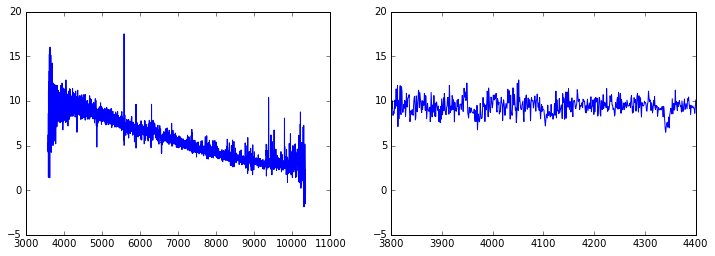

In [31]:
plot_spec(3760,55268,863,good_WD)

(array([  1.,   9.,  31.,  35.,  18.,  13.,  12.,   3.,   5.,   4.]),
 array([-100,    0,  100,  200,  300,  400,  500,  600,  700,  800,  900]),
 <a list of 10 Patch objects>)

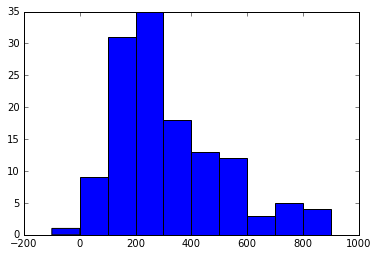

In [38]:
plt.hist(good_WD['Chi1_5'],bins=[-100,0,100,200,300,400,500,600,700,800,900])


(-150.0, 150.0)

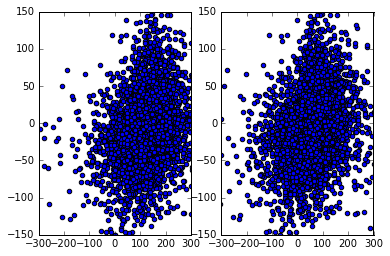

In [102]:
plt.subplot(121)
plt.scatter((3.e5*(good_WD['X1_2']-4861))/4861,3.e5*(good_WD['z']))
plt.xlim([3.e5*-0.001,0.001*3.e5])
plt.ylim([3.e5*-0.0005,0.0005*3.e5])

plt.subplot(122)
plt.scatter(((3.e5*(good_WD['X1_2']-4861))/4861)-good_WD['helio_rv']-70.,3.e5*(good_WD['z']))
plt.xlim([3.e5*-0.001,0.001*3.e5])
plt.ylim([3.e5*-0.0005,0.0005*3.e5])

In [1]:
#plt.scatter(good_WD['Chi1'],good_WD['S_N'])
plt.subplot(321)
plt.scatter(good_WD['Chi1_0'],good_WD['S_N'],marker='.')

plt.subplot(322)
plt.scatter(good_WD['Chi1_1'],good_WD['S_N'],marker='.')

plt.subplot(323)
plt.scatter(good_WD['Chi1_2'],good_WD['S_N'],marker='.')

plt.subplot(324)
plt.scatter(good_WD['Chi1_3'],good_WD['S_N'],marker='.')

plt.subplot(325)
plt.scatter(good_WD['Chi1_4'],good_WD['S_N'],marker='.')

plt.subplot(326)
plt.scatter(good_WD['Chi1_5'],good_WD['S_N'],marker='.')

NameError: name 'plt' is not defined

In [104]:
good_WD
good_WD.write('DA_with_LP_Mike.dat', format='ascii')

(array([ 535.,  538.,  613.,  670.,  618.,  510.,  492.,  345.,  296.,  196.]),
 array([-0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
         0.04,  0.05]),
 <a list of 10 Patch objects>)

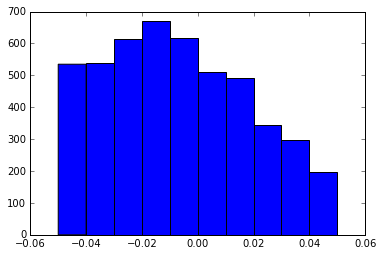

In [71]:
plt.hist(good_WD['M5'],bins=[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])

12753.6434899


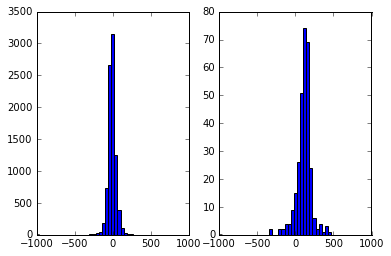

In [98]:
plt.subplot(121)
plt.hist(good_WD['z']*3.e5,bins=np.linspace(-1000,1000,50))

plt.subplot(122)
plt.hist(3.e5*(good_WD['X1_1']-4861)/4861,bins=np.linspace(-1000,1000,50))

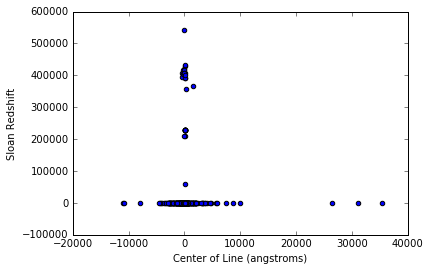

In [27]:
plt.scatter((good_WD['X0']-6563)*3*10**5/6563,good_WD['z']*3*10**5)
#plt.ylim([-0.002,0.002])
#plt.xlim([-5000,5000])
plt.xlabel('Center of Line (angstroms)')
plt.ylabel('Sloan Redshift')

#Chi squared with square root of flux array in place of uncertainty

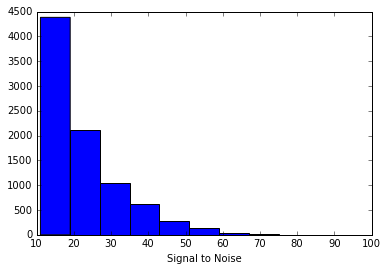

In [28]:
plt.hist(good_WD['S_N'])
plt.xlabel('Signal to Noise')

### Create training, test, and validation sets

In [29]:
# Randomly shuffle indices
indices = np.arange(len(good_WD))
np.random.shuffle(indices)
good_shuffle_WD = good_WD[indices]

# Determine training, test, and validation sets
validation_WD = good_shuffle_WD[0:300]
test_WD = good_shuffle_WD[300:600]
training_WD = good_shuffle_WD[600:]

### Plot up systems in T_eff and log g space to see where they lie

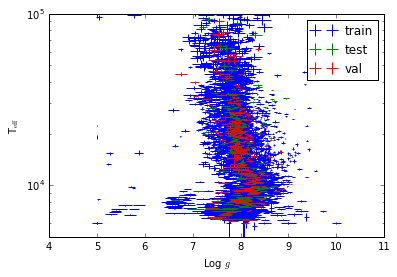

In [30]:
plt.errorbar(training_WD['logg'], training_WD['Teff'], xerr=training_WD['e_logg'], 
             yerr=training_WD['e_Teff'], ls='none', fmt='', capsize=0, label='train')

plt.errorbar(test_WD['logg'], test_WD['Teff'], xerr=test_WD['e_logg'], 
             yerr=test_WD['e_Teff'], ls='none', fmt='', capsize=0, label='test')

plt.errorbar(validation_WD['logg'], validation_WD['Teff'], xerr=validation_WD['e_logg'], 
             yerr=validation_WD['e_Teff'], ls='none', fmt='', capsize=0, label='val')
plt.legend()


plt.ylabel(r'T$_{\rm eff}$')
plt.xlabel(r'Log $g$')

plt.yscale('log')
plt.ylim(5.0e3, 1.0e5)

plt.show()

Now we will look at just the DAs.

In [31]:
set(good_WD['SpType'])

TypeError: unhashable type: 'MaskedConstant'

In [ ]:
DA_good = good_WD

print("Number of DAs in sample",len(DA_good))

In [ ]:
plt.errorbar(DA_good['Teff'], DA_good['logg'],yerr=DA_good['e_logg'], 
             xerr=DA_good['e_Teff'], ls='none', fmt='', capsize=0)


plt.xlabel(r'T$_{\rm eff}$')
plt.ylabel(r'Log $g$')

plt.xscale('log')
plt.xlim(5.0e3, 1.0e5)

plt.show()

In [ ]:
plt.errorbar(good_WD['Teff_3D_'], good_WD['logg_3D_'],yerr=good_WD['e_logg_3D_'], 
             xerr=good_WD['e_Teff_3D_'], ls='none', fmt='', capsize=0)


plt.xlabel(r'T$_{\rm eff}$')
plt.ylabel(r'Log $g$')

plt.xscale('log')
plt.xlim(5.0e3, 1.0e5)

plt.show()

In [ ]:
plt.hist(good_WD['logg'])
plt.xlabel(r'Log $g$')

In [ ]:
plt.hist(good_WD['Teff'])
plt.xlabel(r'T$_{\rm eff}$')

In [69]:
ascii.write(DA_good, 'DA_good.csv', format='csv', include_names=['_RAJ2000','_DEJ2000','SDSS','S_N','umag','e_umag','gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','E_B-V_','pm'])

NameError: name 'DA_good' is not defined

In [ ]:
ind = []
for num,thing in enumerate(good_WD['SpType']):
    if 'A' in thing:
        ind += [num]

All_A = good_WD[ind]
print("Number of As in sample",len(All_A))

In [ ]:
All_A

In [ ]:
plt.errorbar(All_A['Teff'], All_A['logg'],yerr=All_A['e_logg'], 
             xerr=All_A['e_Teff'], ls='none', fmt='', capsize=0, color='red')


plt.xlabel(r'T$_{\rm eff}$')
plt.ylabel(r'Log $g$')

plt.xscale('log')
plt.xlim(5.0e3, 1.0e5)

plt.show()